In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)
                           
from idaes.core import FlowsheetBlock
from pyomo.opt import TerminationCondition, SolverStatus
                           
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
                           

from HFCS_bmimPF6_PR import configuration as config


from idaes.generic_models.unit_models import Flash

from idaes.core.util.model_statistics import degrees_of_freedom

import idaes.logger as idaeslog

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

In [2]:
m1 = ConcreteModel()

m1.fs = FlowsheetBlock(default={"dynamic": False})

m1.fs.properties = GenericParameterBlock(default=config)

m1.fs.F101 = Flash(default={"property_package": m1.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m2 = ConcreteModel()

m2.fs = FlowsheetBlock(default={"dynamic": False})

m2.fs.properties = GenericParameterBlock(default=config)

m2.fs.F101 = Flash(default={"property_package": m2.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})



2021-05-05 01:38:28 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
2021-05-05 01:38:28 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.


In [3]:
m1.fs.properties.PR_kappa['R32', 'R125'].fix(-0.002535)
m1.fs.properties.PR_kappa['R125', 'R32'].fix(-0.002535)
m1.fs.properties.PR_kappa['R32', 'bmimPF6'].fix(-0.01435)
m1.fs.properties.PR_kappa['bmimPF6', 'R32'].fix(0.9651)
m1.fs.properties.PR_kappa['bmimPF6', 'R125'].fix(0.6312)
m1.fs.properties.PR_kappa['R125', 'bmimPF6'].fix(0.0504)

m2.fs.properties.PR_kappa['R32', 'R125'].fix(-0.002535)
m2.fs.properties.PR_kappa['R125', 'R32'].fix(-0.002535)
m2.fs.properties.PR_kappa['R32', 'bmimPF6'].fix(-0.05355)
m2.fs.properties.PR_kappa['bmimPF6', 'R32'].fix(0.1818)
m2.fs.properties.PR_kappa['bmimPF6', 'R125'].fix(1.6358)
m2.fs.properties.PR_kappa['R125', 'bmimPF6'].fix(0.04800)

In [4]:
m1.fs.F101.inlet.flow_mol.fix(1)
m1.fs.F101.inlet.temperature.fix(298.15)
m1.fs.F101.inlet.pressure.fix(100000)
m1.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.2)
m1.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(0.1)
m1.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].fix(0.7)

m2.fs.F101.inlet.flow_mol.fix(1)
m2.fs.F101.inlet.temperature.fix(298.15)
m2.fs.F101.inlet.pressure.fix(100000)
m2.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.2)
m2.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(0.1)
m2.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].fix(0.7)

In [5]:
m1.fs.F101.vap_outlet.pressure.fix(100000)
m2.fs.F101.vap_outlet.pressure.fix(100000)

m1.fs.F101.vap_outlet.temperature.fix(286.15)
m2.fs.F101.vap_outlet.temperature.fix(286.15)

In [6]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [7]:
P = [100000]
T = [286,300,310,320,330,340,350,360,370,380,390,400]

IL_x1 = np.zeros((len(P),(len(T))))
IL_y1 = np.zeros((len(P),(len(T))))
R32_x1 = np.zeros((len(P),(len(T))))
R32_y1 = np.zeros((len(P),(len(T))))
R125_x1 = np.zeros((len(P),(len(T))))
R125_y1 = np.zeros((len(P),(len(T))))
L1 = np.zeros((len(P),(len(T))))
V1 = np.zeros((len(P),(len(T))))

IL_x2 = np.zeros((len(P),(len(T))))
IL_y2 = np.zeros((len(P),(len(T))))
R32_x2 = np.zeros((len(P),(len(T))))
R32_y2 = np.zeros((len(P),(len(T))))
R125_x2 = np.zeros((len(P),(len(T))))
R125_y2 = np.zeros((len(P),(len(T))))
L2 = np.zeros((len(P),(len(T))))
V2 = np.zeros((len(P),(len(T))))

for j in range(len(T)):
    m1.fs.F101.vap_outlet.temperature.fix(T[j])
    m2.fs.F101.vap_outlet.temperature.fix(T[j])
    
    for i in range(len(P)):

        print(P[i])

        m1.fs.F101.vap_outlet.pressure.fix(P[i])
        m2.fs.F101.vap_outlet.pressure.fix(P[i])

        m1.fs.F101.initialize(outlvl=idaeslog.CRITICAL)    
        m2.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        # solve the model
        status1 = solver.solve(m1, tee = False)
        status2 = solver.solve(m2, tee = False)

        # model.display()
        # If solution is optimal store the concentration, and calculated temperatures in the created arrays
        if (status1.solver.status == SolverStatus.ok) and (status1.solver.termination_condition == TerminationCondition.optimal):

            IL_x1[i,j] = value(m1.fs.F101.liq_outlet.mole_frac_comp[0, "bmimPF6"])
            IL_y1[i,j] = value(m1.fs.F101.vap_outlet.mole_frac_comp[0, "bmimPF6"])
            R32_x1[i,j] = value(m1.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
            R32_y1[i,j] = value(m1.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
            R125_x1[i,j] = value(m1.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
            R125_y1[i,j] = value(m1.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])
            L1[i,j] = value(m1.fs.F101.liq_outlet.flow_mol[0])
            V1[i,j] = value(m1.fs.F101.vap_outlet.flow_mol[0])

        else:
            IL_x1[i,j] = "NAN"
            IL_y1[i,j] = "NAN"
            R32_x1[i,j] = "NAN"
            R32_y1[i,j] = "NAN"
            R125_x1[i,j] = "NAN"
            R125_y1[i,j] = "NAN"
            L1[i,j] = "NAN"
            V1[i,j] = "NAN"
            
        if (status2.solver.status == SolverStatus.ok) and (status2.solver.termination_condition == TerminationCondition.optimal):
            IL_x2[i,j] = value(m2.fs.F101.liq_outlet.mole_frac_comp[0, "bmimPF6"])
            IL_y2[i,j] = value(m2.fs.F101.vap_outlet.mole_frac_comp[0, "bmimPF6"])
            R32_x2[i,j] = value(m2.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
            R32_y2[i,j] = value(m2.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
            R125_x2[i,j] = value(m2.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
            R125_y2[i,j] = value(m2.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])
            L2[i,j] = value(m2.fs.F101.liq_outlet.flow_mol[0])
            V2[i,j] = value(m2.fs.F101.vap_outlet.flow_mol[0])

        else:
            IL_x2[i,j] = "NAN"
            IL_y2[i,j] = "NAN"
            R32_x2[i,j] = "NAN"
            R32_y2[i,j] = "NAN"
            R125_x2[i,j] = "NAN"
            R125_y2[i,j] = "NAN"
            L2[i,j] = "NAN"
            V2[i,j] = "NAN"

100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000
100000


In [8]:
VR32_1 = np.zeros((len(P),(len(T))))
VR125_1 = np.zeros((len(P),(len(T))))
LR32_1 = np.zeros((len(P),(len(T))))
LR125_1 = np.zeros((len(P),(len(T))))

VR32_2 = np.zeros((len(P),(len(T))))
VR125_2 = np.zeros((len(P),(len(T))))
LR32_2 = np.zeros((len(P),(len(T))))
LR125_2 = np.zeros((len(P),(len(T))))

for j in range(len(T)):
    for i in range(len(P)):
        VR32_1[i,j] = R32_y1[i,j] * V1[i,j]
        VR125_1[i,j] = R125_y1[i,j] * V1[i,j]
        LR32_1[i,j] = R32_x1[i,j] * L1[i,j]
        LR125_1[i,j] = R125_x1[i,j] * L1[i,j]

        VR32_2[i,j] = R32_y2[i,j] * V2[i,j]
        VR125_2[i,j] = R125_y2[i,j] * V2[i,j]
        LR32_2[i,j] = R32_x2[i,j] * L2[i,j]
        LR125_2[i,j] = R125_x2[i,j] * L2[i,j]

In [9]:
PVR32_1 = np.zeros((len(P),(len(T))))
PVR125_1 = np.zeros((len(P),(len(T))))
PLR32_1 = np.zeros((len(P),(len(T))))
PLR125_1 = np.zeros((len(P),(len(T))))

PVR32_2 = np.zeros((len(P),(len(T))))
PVR125_2 = np.zeros((len(P),(len(T))))
PLR32_2 = np.zeros((len(P),(len(T))))
PLR125_2 = np.zeros((len(P),(len(T))))

for j in range(len(T)):
    for i in range(len(P)):
        PVR32_1[i,j] = VR32_1[i,j]/0.2
        PVR125_1[i,j] = VR125_1[i,j]/0.1
        PLR32_1[i,j] = LR32_1[i,j]/0.2
        PLR125_1[i,j] = LR125_1[i,j]/0.1

        PVR32_2[i,j] = VR32_2[i,j]/0.2
        PVR125_2[i,j] = VR125_2[i,j]/0.1
        PLR32_2[i,j] = LR32_2[i,j]/0.2
        PLR125_2[i,j] = LR125_2[i,j]/0.1

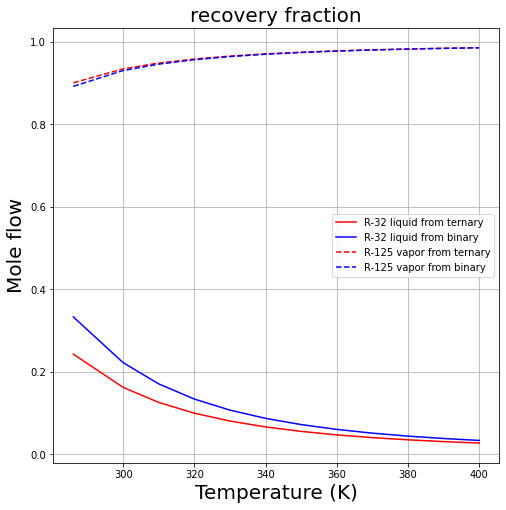

In [11]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)

plt.plot(T,PLR32_1[0,:],linestyle='-', color='red',label="R-32 liquid from ternary")  
plt.plot(T,PLR32_2[0,:],linestyle='-', color='blue',label="R-32 liquid from binary")    
plt.plot(T,PVR125_1[0,:], linestyle='--', color='red',label="R-125 vapor from ternary")  
plt.plot(T,PVR125_2[0,:], linestyle='--', color='blue',label="R-125 vapor from binary")   

ax.set_title("recovery fraction",fontsize=20)
plt.xlabel('Temperature (K)',fontsize=20)
plt.ylabel('Mole flow',fontsize=20)
plt.grid(True)
plt.legend()
# ax.set_ylim([0.01, 0.25])
# ax.set_xlim([1e5, 2.5e5])
plt.show()

In [1]:
MFVR32_1 = np.zeros((len(P),(len(T))))
MFVR125_1 = np.zeros((len(P),(len(T))))
MFLR32_1 = np.zeros((len(P),(len(T))))
MFLR125_1 = np.zeros((len(P),(len(T))))

MFVR32_2 = np.zeros((len(P),(len(T))))
MFVR125_2 = np.zeros((len(P),(len(T))))
MFLR32_2 = np.zeros((len(P),(len(T))))
MFLR125_2 = np.zeros((len(P),(len(T))))

for j in range(len(T)):
    for i in range(len(P)):
        MFVR32_1[i,j] = R32_y1[i,j] / (R32_y1[i,j]+R125_y1[i,j])
        MFVR125_1[i,j] = R125_y1[i,j] / (R32_y1[i,j]+R125_y1[i,j])
        MFLR32_1[i,j] = R32_x1[i,j] / (R32_x1[i,j]+R125_x1[i,j])
        MFLR125_1[i,j] = R125_x1[i,j] / (R32_x1[i,j]+R125_x1[i,j])

        MFVR32_2[i,j] = R32_y2[i,j] / (R32_y2[i,j]+R125_y2[i,j])
        MFVR125_2[i,j] = R125_y2[i,j] / (R32_y2[i,j]+R125_y2[i,j])
        MFLR32_2[i,j] = R32_x2[i,j] / (R32_x2[i,j]+R125_x2[i,j])
        MFLR125_2[i,j] = R125_x2[i,j] / (R32_x2[i,j]+R125_x2[i,j])


NameError: name 'np' is not defined

In [ ]:
PMP = np.zeros((len(P)))
for i in range(len(P)):
    PMP[i] = P[i]/1e6

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)

plt.plot(PMP,MFLR32_1[:,7],linestyle='-', color='red',label="R-32 liquid from ternary")  
plt.plot(PMP,MFLR32_2[:,7],linestyle='-', color='blue',label="R-32 liquid from binary")  
# plt.plot(PMP,MFLR125_1[:,8],linestyle='-', color='red',label="R-32 liquid from ternary")  
# plt.plot(PMP,MFLR125_2[:,8],linestyle='-', color='blue',label="R-32 liquid from binary")  
plt.plot(PMP,MFVR125_1[:,7], linestyle='-.', color='red',label="R-125 vapor from ternary")  
plt.plot(PMP,MFVR125_2[:,7], linestyle='-.', color='blue',label="R-125 vapor from binary")  
# plt.plot(PMP,MFVR32_1[:,8], linestyle='--', color='red',label="R-32 vapor from ternary")  
# plt.plot(PMP,MFVR32_2[:,8], linestyle='--', color='blue',label="R-32 vapor from binary")  
ax.set_title("mole fraction",fontsize=20)
plt.xlabel('Pressure (MPa)',fontsize=20)
plt.ylabel('Mole fraction',fontsize=20)
plt.grid(True)
plt.legend()
# ax.set_ylim([0.01, 0.25])
# ax.set_xlim([1e5, 2.5e5])
plt.show()